Scripts for regression experiments on B.subtilis

In [34]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import mp_run
from scipy import stats
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
from multiprocessing import Pool, cpu_count


# regex for number extraction from string
number_pattern =  r'(-?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+-]?\d+)?)'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ref_res_df = pd.read_csv('../output/network_model/bsubtilis_all_tf_high_var_target_efron_train.csv.gz', compression='gzip', index_col=0)

In [3]:
source_df_1 = pd.read_csv('../data/bsubtilis/GSE108659/normalized/source.csv.gz', index_col=0, compression='gzip')
source_df_2 = pd.read_csv('../data/bsubtilis/GSE128875/normalized/source.csv.gz', index_col=0, compression='gzip')
source_df_3 = pd.read_csv('../data/bsubtilis/GSE224332/normalized/source.csv.gz', index_col=0, compression='gzip')
target_df_1 = pd.read_csv('../data/bsubtilis/GSE108659/normalized/target.csv.gz', index_col=0, compression='gzip')
target_df_2 = pd.read_csv('../data/bsubtilis/GSE128875/normalized/target.csv.gz', index_col=0, compression='gzip')
target_df_3 = pd.read_csv('../data/bsubtilis/GSE224332/normalized/target.csv.gz', index_col=0, compression='gzip')

In [4]:
train_source_df_1 = pd.read_csv('../data/bsubtilis/GSE108659/normalized/train_source.csv.gz', index_col=0, compression='gzip')
train_source_df_2 = pd.read_csv('../data/bsubtilis/GSE128875/normalized/train_source.csv.gz', index_col=0, compression='gzip')
train_source_df_3 = pd.read_csv('../data/bsubtilis/GSE224332/normalized/train_source.csv.gz', index_col=0, compression='gzip')
train_target_df_1 = pd.read_csv('../data/bsubtilis/GSE108659/normalized/train_target.csv.gz', index_col=0, compression='gzip')
train_target_df_2 = pd.read_csv('../data/bsubtilis/GSE128875/normalized/train_target.csv.gz', index_col=0, compression='gzip')
train_target_df_3 = pd.read_csv('../data/bsubtilis/GSE224332/normalized/train_target.csv.gz', index_col=0, compression='gzip')

test_source_df_1 = pd.read_csv('../data/bsubtilis/GSE108659/normalized/test_source.csv.gz', index_col=0, compression='gzip')
test_source_df_2 = pd.read_csv('../data/bsubtilis/GSE128875/normalized/test_source.csv.gz', index_col=0, compression='gzip')
test_source_df_3 = pd.read_csv('../data/bsubtilis/GSE224332/normalized/test_source.csv.gz', index_col=0, compression='gzip')
test_target_df_1 = pd.read_csv('../data/bsubtilis/GSE108659/normalized/test_target.csv.gz', index_col=0, compression='gzip')
test_target_df_2 = pd.read_csv('../data/bsubtilis/GSE128875/normalized/test_target.csv.gz', index_col=0, compression='gzip')
test_target_df_3 = pd.read_csv('../data/bsubtilis/GSE224332/normalized/test_target.csv.gz', index_col=0, compression='gzip')

In [5]:
regulator_set = set()
tf_list_df = pd.read_csv('../data/bsubtilis/bsubtilis_tf_list.tsv.gz', sep='\t', compression='gzip', index_col=0)
tf_list_df
for name in tf_list_df['Gene Names']:
    name_splits = name.split(' ')
    for i in name_splits:
        if i in source_df_1.index:
            regulator_set.add(i)

network_df = pd.read_csv('../data/bsubtilis/gs_regulations.csv')
regulator_set = regulator_set.union(set(network_df['regulator name']))
target_set = set(network_df['gene name'])



In [6]:
regulator_set = regulator_set.intersection(set(source_df_1.index), set(source_df_2.index), set(source_df_3.index))
target_set = target_set.intersection(set(source_df_1.index), set(source_df_2.index), set(source_df_3.index))
all_gene_set = regulator_set.union(target_set)


In [7]:
network_dict = {target: [] for target in target_set}
for ind, row in network_df.iterrows():
    if (row['regulator name'] in regulator_set) and (row['gene name'] in target_set):
        network_dict[row['gene name']].append(row['regulator name'])

In [8]:
key_list = []
value_list = []
regulator_set = set()
target_set = set()
for key in network_dict.keys():
    if (len(network_dict[key]) > 0):
        key_list.append(key)
        target_set.add(key)
        value_list.append("; ".join(network_dict[key]))
        for regulator in network_dict[key]:
            regulator_set.add(regulator)
all_gene_set = regulator_set.union(target_set)

In [9]:
network_df = pd.DataFrame(index=key_list)
network_df['tf_list'] = value_list

In [10]:
source_df_1 = source_df_1.loc[list(all_gene_set)]
source_df_2 = source_df_2.loc[list(all_gene_set)]
source_df_3 = source_df_3.loc[list(all_gene_set)]
target_df_1 = target_df_1.loc[list(all_gene_set)]
target_df_2 = target_df_2.loc[list(all_gene_set)]
target_df_3 = target_df_3.loc[list(all_gene_set)]

train_source_df_1 = train_source_df_1.loc[list(all_gene_set)]
train_source_df_2 = train_source_df_2.loc[list(all_gene_set)]
train_source_df_3 = train_source_df_3.loc[list(all_gene_set)]
train_target_df_1 = train_target_df_1.loc[list(all_gene_set)]
train_target_df_2 = train_target_df_2.loc[list(all_gene_set)]
train_target_df_3 = train_target_df_3.loc[list(all_gene_set)]

test_source_df_1 = test_source_df_1.loc[list(all_gene_set)]
test_source_df_2 = test_source_df_2.loc[list(all_gene_set)]
test_source_df_3 = test_source_df_3.loc[list(all_gene_set)]
test_target_df_1 = test_target_df_1.loc[list(all_gene_set)]
test_target_df_2 = test_target_df_2.loc[list(all_gene_set)]
test_target_df_3 = test_target_df_3.loc[list(all_gene_set)]


In [11]:
train_source = pd.concat([train_source_df_1, train_source_df_2, train_source_df_3], axis=1).apply(stats.zscore, axis=0)
test_source = pd.concat([test_source_df_1, test_source_df_2, test_source_df_3], axis=1).apply(stats.zscore, axis=0)
train_target = pd.concat([train_target_df_1, train_target_df_2, train_target_df_3], axis=1).apply(stats.zscore, axis=0)
test_target = pd.concat([test_target_df_1, test_target_df_2, test_target_df_3], axis=1).apply(stats.zscore, axis=0)

target_df = pd.concat([target_df_1, target_df_2, target_df_3], axis=1).apply(stats.zscore, axis=0)
source_df = pd.concat([source_df_1, source_df_2, source_df_3], axis=1).apply(stats.zscore, axis=0)






In [12]:
train_source_list = [train_source_df_1, train_source_df_2, train_source_df_3]
train_target_list = [train_target_df_1, train_target_df_2, train_target_df_3]
test_source_list = [test_source_df_1, test_source_df_2, test_source_df_3]
test_target_list = [test_target_df_1, test_target_df_2, test_target_df_3]

In [13]:
for a in list(target_set):
    if len(network_df.loc[a]['tf_list'].split('; ')) < 1 or network_df.loc[a]['tf_list'] == a:
        target_set.remove(a)
    

In [14]:
target_gene_list = list(target_set)
target_exp = target_df
X = source_df.loc[list(regulator_set)]
tf_list = list(regulator_set)
# target_gene_list = list(ref_res_df.index)
tf_list_df = pd.read_csv('../output/network_model/bsubtilis_tf.csv', names=['tf'], index_col=0)
tf_list = list(tf_list_df.index)

In [26]:
res_df = pd.read_csv('../output/network_model/bsubtilis_full_results.csv.gz', index_col=0, compression='gzip')
rmse_list = [res_df['rf_rmse'].mean()]
error_list = [res_df['rf_rmse'].sem()]

In [27]:
all_rmse_list = []
all_train_rmse_list = []
all_train_source = pd.concat(train_source_list, axis=1)
all_train_target = pd.concat(train_target_list, axis=1)

for i in range(len(train_source_list)):
    cv_test_source = test_source_list[i]
    cv_test_target = test_target_list[i]
    cv_train_source = train_source_list[i]
    cv_train_target = train_target_list[i]
    new_test_target = cv_test_target
    new_test_target = new_test_target.loc[new_test_target.std(axis=1) > 0.5]
    new_target_gene_list = new_test_target.index
    mp_calc = mp_run.MpCalc(new_target_gene_list, X, network_df, cv_train_source.loc[tf_list], cv_train_target, cv_test_source.loc[tf_list], cv_test_target)
    iter_length = len(new_target_gene_list)
    if (iter_length < 1): continue
    with Pool(cpu_count()) as p:
        r = list(tqdm(p.imap(mp_calc.full_comp_new, range(iter_length)), total=iter_length))
    r = np.array(r)
    out_df = pd.DataFrame(index=new_target_gene_list)
    out_df['rf_rmse'] = r[:, 6]
    rmse_list.append(out_df['rf_rmse'].mean())
    error_list.append(out_df['rf_rmse'].sem())
    
    # all_rmse_list = np.concatenate([all_rmse_list, r[:, 6]])
    # print(out_df['rf_rmse'].mean())
    # print(out_df['rf_score'].mean())

    # mp_calc = mp_run.MpCalc(new_target_gene_list, X, network_df, all_train_source.loc[tf_list], all_train_target, cv_test_source.loc[tf_list], cv_test_target)
    # iter_length = len(new_target_gene_list)
    # with Pool(cpu_count()) as p:
    #     r = list(tqdm(p.imap(mp_calc.full_comp_new, range(iter_length)), total=iter_length))
    # r = np.array(r)
    # print(np.mean(r[:, 6]))
    # all_train_rmse_list = np.concatenate([all_train_rmse_list, r[:, 6]])


#     print('======================================')
# print(np.mean(all_rmse_list))
# print(np.mean(all_train_rmse_list))

100%|██████████| 6/6 [00:00<00:00,  7.77it/s]


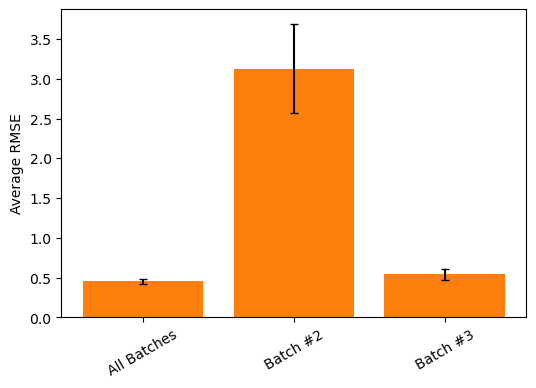

In [38]:

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(['All Batches','Batch #2','Batch #3'], rmse_list, color=colors[1], yerr=error_list, capsize=3)
ax.set(ylabel='Average RMSE')
plt.xticks(rotation=30)
plt.savefig('./plot_output/batch_comp/bsubtilis.pdf', bbox_inches='tight')